<h1>Supervised transfer learning on synthetic data</h1>

# Table of contents
1. [Supervised transfer learning on linear models](#lin_m)
    1. [Regression 1-d](#reg)
        1. [Example 1 : affine regression function with normal distribution](#ex1_reg)
        2. [Example 2 : pseudo-periodic regression function with uniform distribution](#ex2_reg)
    2. [Binary classification 2-d](#classif)
        1. [Example 1 : two gaussian clusters classification](#ex1_classif)
        2. [Example 2 : pseudo-periodic classification](#ex2_classif)
2. [Supervised transfer learning on decision tree models](#dt)
    1. [Example 1 : decision tree for pseudo-periodic classification](#dt_sin)
    2. [Example 2 : decision tree for two gaussian clusters classification](#dt_2clust)
    3. [Example 3 : random forest for numerous gaussian clusters classification](#rf_clust)
        1. [Same source/target distributions](#rf_nochange)
        2. [Unrelated source/target distributions](#rf_tgt)
        3. [Translation between source/target clusters](#rf_translation)
        4. [Addition/deletion of clusters between source/target](#rf_add_del)


In [92]:
import sys
import copy
import pandas as pd
import  numpy as np
import sklearn.metrics as metr
import sklearn.model_selection as select
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [93]:
#!pip install adapt
import adapt._tree_utils as ut
from adapt.parameter_based import TransferTreeClassifier, TransferForestClassifier
from adapt.parameter_based  import TransferTreeSelector, TransferForestSelector

<h2>Supervised transfer learning on linear models </h2><a name="lin_m"></a>

<h3>Supervised transfer learning for 1-d regression : </h3><a name="reg"></a>

#### Example 1 : affine regression function with normal distribution <a name="ex1_reg"></a>

In [94]:
from plot_utils import plot_dots, plot_dec_func, show_reg1d, plot_1d_func, plot_dec_func_explicite

def label_func(x,beta=2,noise=0.1):
    return beta*x + noise * np.random.randn(len(x))

def gaussian(x, mu=0., s=1.):
    return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -(x-mu)**2 / ( 2. * s**2 ) )

def mse(y1,y2):
    return np.mean(np.square(y1 - y2))

np.random.seed(0)
mu_s = -1
mu_t = 1
sigma_t = 1
sigma_s = 1
beta = 2
var=1
epsilon = var*np.random.randn(1)[0]

n_src = 100
n_tgt = 100

Xs_all = np.random.randn(n_src) * sigma_s + mu_s
Xt_all = np.random.randn(n_tgt) * sigma_t + mu_t
ys_all = label_func(Xs_all,beta=beta,noise=1)
yt_all = label_func(Xt_all,beta=beta+epsilon,noise=1)

n_train_s = 5
n_train_t = 5

Xs = Xs_all[:n_train_s]
ys = ys_all[:n_train_s]
Xt = Xt_all[:n_train_t]
yt = yt_all[:n_train_t]

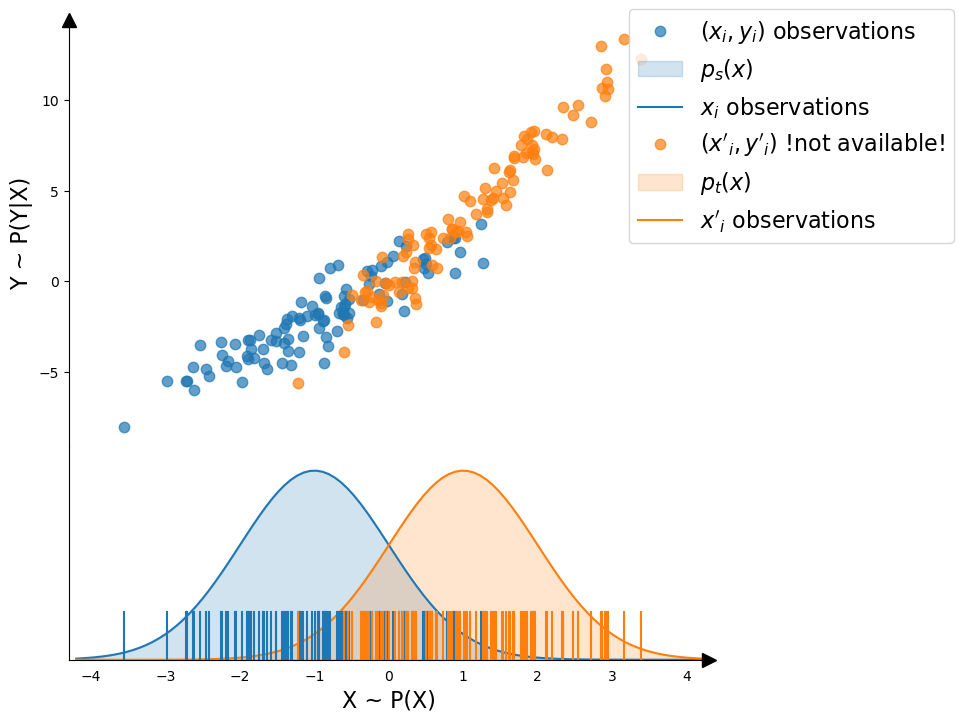

In [95]:
show_reg1d(Xs_all, Xt_all, ys_all, yt_all, mu_s=mu_s,mu_t=mu_t)

In [96]:
from sklearn.linear_model import LinearRegression
from adapt.parameter_based import RegularTransferLR

source_model = LinearRegression()
source_model.fit(Xs.reshape(-1, 1), ys)

only_tgt_model = LinearRegression()
only_tgt_model.fit(Xt.reshape(-1, 1), yt)

tr_model = RegularTransferLR(source_model, lambda_=1)
tr_model.fit(Xt.reshape(-1, 1), yt)

print('Source model error on source :',mse(source_model.predict(Xs.reshape(-1, 1)),ys))
print('Target model error on target :',mse(only_tgt_model.predict(Xt.reshape(-1, 1)),yt))

print('Source model error on target :',mse(source_model.predict(Xt.reshape(-1, 1)),yt))
print('Target model error on source :',mse(only_tgt_model.predict(Xs.reshape(-1, 1)),ys))

print('Transferred model error on source :',mse(tr_model.predict(Xs.reshape(-1, 1)),ys))
print('Transferred model error on target :',mse(tr_model.predict(Xt.reshape(-1, 1)),yt))

Source model error on source : 0.24305038192893083
Target model error on target : 0.34840520170366973
Source model error on target : 1.7788200061930073
Target model error on source : 0.8105499995184466
Transferred model error on source : 0.7390876110101023
Transferred model error on target : 0.3549936853587215


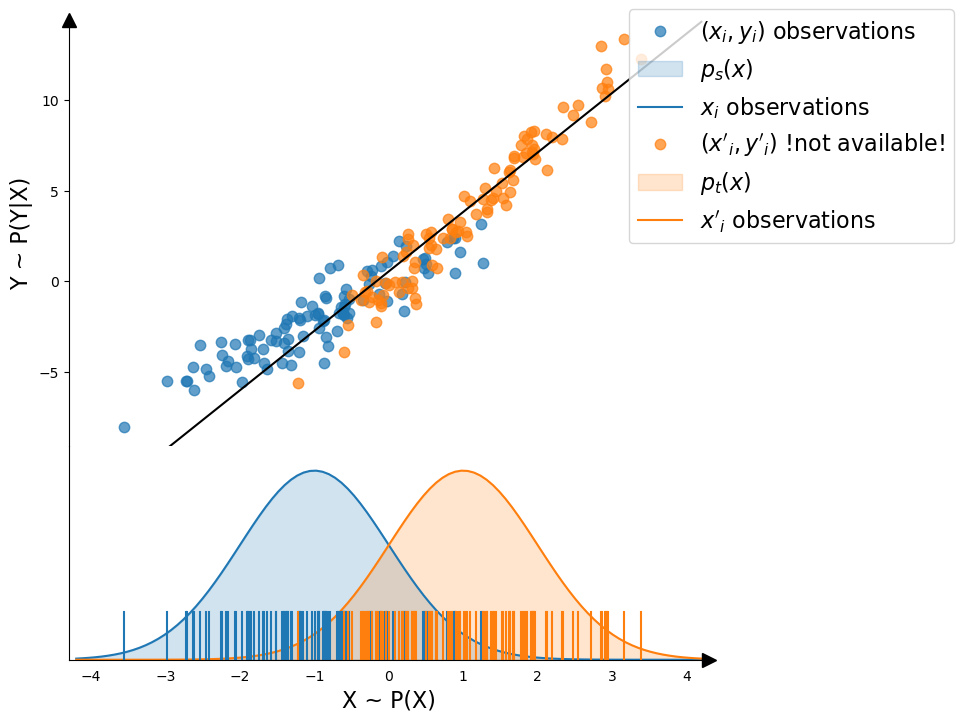

In [97]:
show_reg1d(Xs_all, Xt_all, ys_all, yt_all, model=tr_model, mu_s=mu_s,mu_t=mu_t)

#### Example 2 : pseudo-periodic regression function with uniform distribution <a name="ex2_reg"></a>

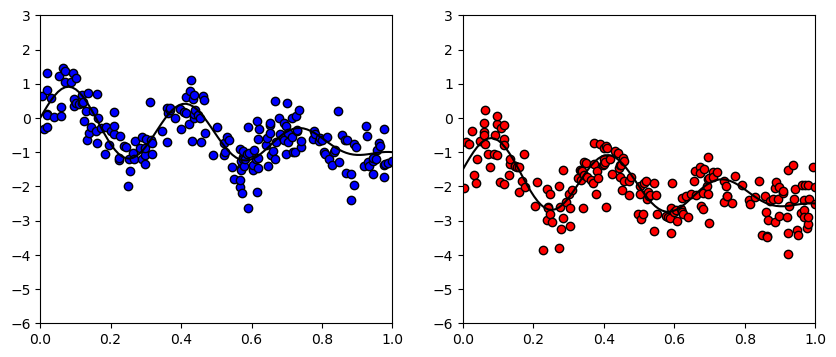

In [98]:
def label_func_sin(X,freq=2,bias=0):
    y = (1 - X**2) * np.sin(freq * 2 * np.pi * X) - X - bias 
    return y

np.random.seed(0)

size_s = 200
size_t = 200

freq_s = 3
freq_t = 3

bias_s = 0
bias_t = 1.5
sig_s = 0.5
sig_t = 0.5

def fs(X):
    return label_func_sin(X,freq=freq_s,bias=bias_s)
def ft(X):
    return label_func_sin(X,freq=freq_t,bias=bias_t)

Xs_reg = np.random.rand(size_s)
Xs_reg = np.sort(Xs_reg)
Ys_reg = fs(Xs_reg) + sig_s * np.random.randn(len(Xs_reg))


#Xt_reg = Xs_reg[:size_t]
Xt_reg = np.random.rand(size_t)
Xt_reg = np.sort(Xt_reg)
Yt_reg = ft(Xt_reg) + sig_t * np.random.randn(len(Xt_reg))

plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
ax[0].scatter(Xs_reg, Ys_reg,marker='o',edgecolor='black',color='blue')
ax[1].scatter(Xt_reg, Yt_reg,marker='o',edgecolor='black',color='red')
plot_1d_func(ax[0], fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')

In [99]:
source_model = LinearRegression()
source_model.fit(Xs_reg.reshape(-1, 1), Ys_reg)

only_tgt_model = LinearRegression()
only_tgt_model.fit(Xt_reg.reshape(-1, 1), Yt_reg)

tr_model = RegularTransferLR(source_model, lambda_=1)
tr_model.fit(Xt_reg.reshape(-1, 1), Yt_reg)

print('Source model error on source :',mse(source_model.predict(Xs_reg.reshape(-1, 1)),Ys_reg))
print('Target model error on target :',mse(only_tgt_model.predict(Xt_reg.reshape(-1, 1)),Yt_reg))

print('Source model error on target :',mse(source_model.predict(Xt_reg.reshape(-1, 1)),Yt_reg))
print('Target model error on source :',mse(only_tgt_model.predict(Xs_reg.reshape(-1, 1)),Ys_reg))

print('Transferred model error on source :',mse(tr_model.predict(Xs_reg.reshape(-1, 1)),Ys_reg))
print('Transferred model error on target :',mse(tr_model.predict(Xt_reg.reshape(-1, 1)),Yt_reg))

Source model error on source : 0.4494330390505663
Target model error on target : 0.47523536602522193
Source model error on target : 2.592257490641698
Target model error on source : 2.5667693096457014
Transferred model error on source : 2.5450070300614236
Transferred model error on target : 0.4754309926021175


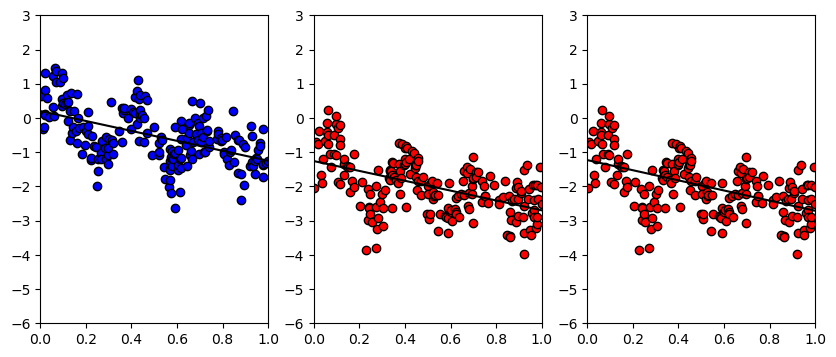

In [101]:
def fs(X):
    return source_model.predict(X.reshape(-1, 1))
def ft(X):
    return only_tgt_model.predict(X.reshape(-1, 1))
def ftr(X):
    return tr_model.predict(X.reshape(-1, 1))

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 4))
ax[0].scatter(Xs_reg, Ys_reg,marker='o',edgecolor='black',color='blue')
ax[1].scatter(Xt_reg, Yt_reg,marker='o',edgecolor='black',color='red')
ax[2].scatter(Xt_reg, Yt_reg,marker='o',edgecolor='black',color='red')

plot_1d_func(ax[0], fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')
plot_1d_func(ax[2], ftr, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')

<h3>Supervised transfer learning for 2-d classification </h3> <a name="classif"></a>

In [102]:
from sklearn.linear_model import SGDClassifier
from adapt.parameter_based import RegularTransferLC

#### Example 1 : two gaussian clusters classification <a name="ex1_classif"></a>

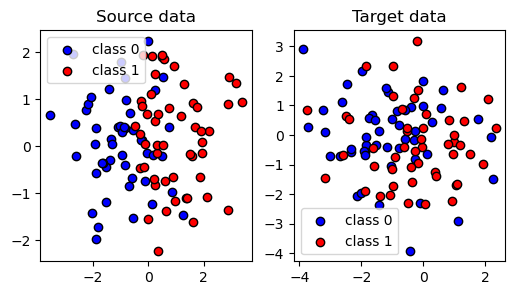

In [103]:
np.random.seed(0)

mean_s_0 = np.array([-1,0])
mean_s_1 = np.array([1,0])
mean_t_0 = np.array([-1,0])
mean_t_1 = np.array([0,0])

sig_s_0 = np.diag([1,1])
sig_s_1 = np.diag([1,1])
sig_t_0 = np.diag([2,2])
sig_t_1 = np.diag([2,2])

size=100
ns_0 = size//2
nt_0 = size//2

Xs_0 = np.random.multivariate_normal(mean_s_0, sig_s_0, size=ns_0)
Xs_1 = np.random.multivariate_normal(mean_s_1, sig_s_1, size=size-ns_0)

Xt_0 = np.random.multivariate_normal(mean_t_0, sig_t_0, size=nt_0)
Xt_1 = np.random.multivariate_normal(mean_t_1, sig_t_1, size=size-nt_0)

Xs = np.r_[Xs_0,Xs_1]
Xt = np.r_[Xt_0,Xt_1]

ys = np.zeros(size)
ys[ns_0:] = 1
yt = np.zeros(size)
yt[nt_0:] = 1

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6, 3))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

Source score on source : 0.78
Source score on target : 0.62


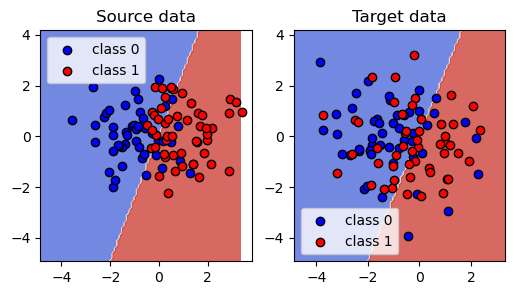

In [104]:
source_model = SGDClassifier()
source_model.fit(Xs,ys)

print('Source score on source :',source_model.score(Xs,ys))
print('Source score on target :',source_model.score(Xt,yt))

#This code plots the Source decision function on Source and Target data

plot_step = 0.1
x_min, x_max = Xt[:, 0].min() - 1, Xt[:, 0].max() + 1
y_min, y_max = Xt[:, 1].min() - 1, Xt[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6, 3))

plot_dec_func(ax[0], source_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_dec_func(ax[1], source_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')

plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [105]:
np.random.seed(0)
source_model = SGDClassifier()
source_model.fit(Xs, ys)

only_tgt_model = SGDClassifier()
only_tgt_model.fit(Xt, yt)

tr_model = RegularTransferLC(source_model, lambda_=0.1)
tr_model.fit(Xt, yt)

print('Source model score on source :',source_model.score(Xs,ys))
print('Target model score on target :',only_tgt_model.score(Xt,yt))

print('Source model score on target :',source_model.score(Xt,yt))
print('Target model score on source :',only_tgt_model.score(Xs,ys))

print('Transferred model score on source :',tr_model.score(Xs,ys))
print('Transferred model score on target :',tr_model.score(Xt,yt))

Source model score on source : 0.78
Target model score on target : 0.56
Source model score on target : 0.65
Target model score on source : 0.6
Transferred model score on source : 0.82
Transferred model score on target : 0.67


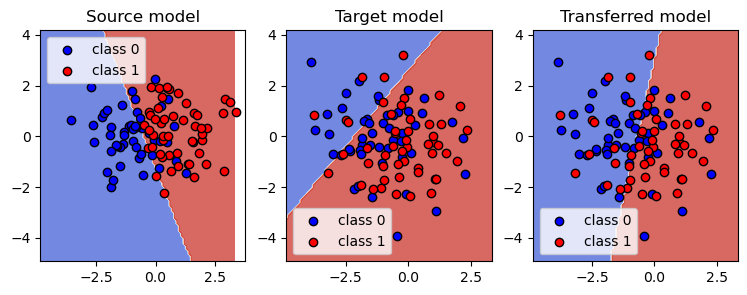

In [106]:
#This code plots the Source decision function on Source and Target data

plot_step = 0.1
x_min, x_max = Xt[:, 0].min() - 1, Xt[:, 0].max() + 1
y_min, y_max = Xt[:, 1].min() - 1, Xt[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(9, 3))

plot_dec_func(ax[0], source_model,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model')
plot_dec_func(ax[1], only_tgt_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model')
plot_dec_func(ax[2], tr_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Transferred model')

plot_dots(ax[0],Xs,ys, title='Source model')
plot_dots(ax[1],Xt,yt, title='Target model')
plot_dots(ax[2],Xt,yt, title='Transferred model')

#### Example 2 : pseudo-periodic classification <a name="ex2_classif"></a>

In [107]:
def label_func_sin(X,freq=2,bias=0):
    y = (1 - X**2) * np.sin(freq * 2 * np.pi * X) - X - bias 
    return y

np.random.seed(0)

size_s = 200
size_t = 200

freq_s = 3
freq_t = 3

bias_s = 0
bias_t = 1.5
sig_s = 0.5
sig_t = 0.5

def fs(X):
    return label_func_sin(X,freq=freq_s,bias=bias_s)
def ft(X):
    return label_func_sin(X,freq=freq_t,bias=bias_t)


Xs = np.zeros((size_s,2))
Xt = np.zeros((size_t,2))

Xs_ = np.random.rand(size_s)
Xs_ = np.sort(Xs_)
#Xt_ = Xs_[:size_t]
Xt_ = np.random.rand(size_t)
Xt_ = np.sort(Xt_)

Xs[:,0] = Xs_
Xs[:,1] = fs(Xs_) + sig_s * np.random.randn(len(Xs_))
ys = Xs[:,1] > fs(Xs_)

Xt[:,0] = Xt_
Xt[:,1] = ft(Xt_) + sig_t * np.random.randn(len(Xt_))
yt = Xt[:,1] > ft(Xt_)

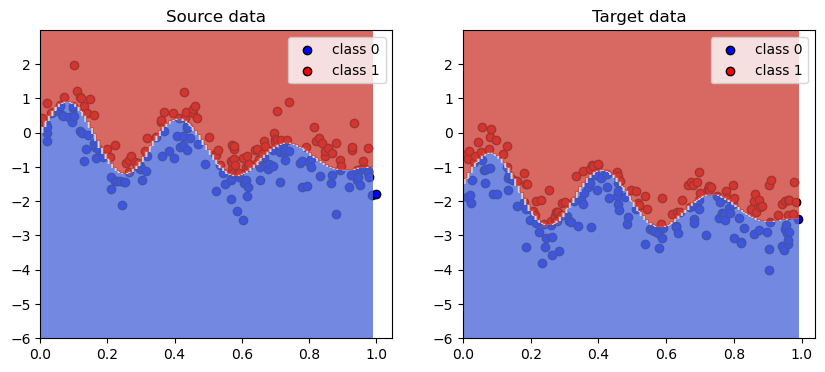

In [108]:
plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

plot_dec_func_explicite(ax[0], fs, x_min, x_max, y_min, y_max, plot_step=plot_step, title='Source data')
plot_dec_func_explicite(ax[1], ft, x_min, x_max, y_min, y_max, plot_step=plot_step, title='Target data')

In [109]:
np.random.seed(0)
source_model = SGDClassifier()
source_model.fit(Xs, ys)

only_tgt_model = SGDClassifier()
only_tgt_model.fit(Xt, yt)

tr_model = RegularTransferLC(source_model, lambda_=0.1)
tr_model.fit(Xt, yt)


print('Source model score on source :',source_model.score(Xs,ys))
print('Target model score on target :',only_tgt_model.score(Xt,yt))

print('Source model score on target :',source_model.score(Xt,yt))
print('Target model score on source :',only_tgt_model.score(Xs,ys))

print('Transferred model score on source :',tr_model.score(Xs,ys))
print('Transferred model score on target :',tr_model.score(Xt,yt))

Source model score on source : 0.645
Target model score on target : 0.69
Source model score on target : 0.555
Target model score on source : 0.535
Transferred model score on source : 0.475
Transferred model score on target : 0.745


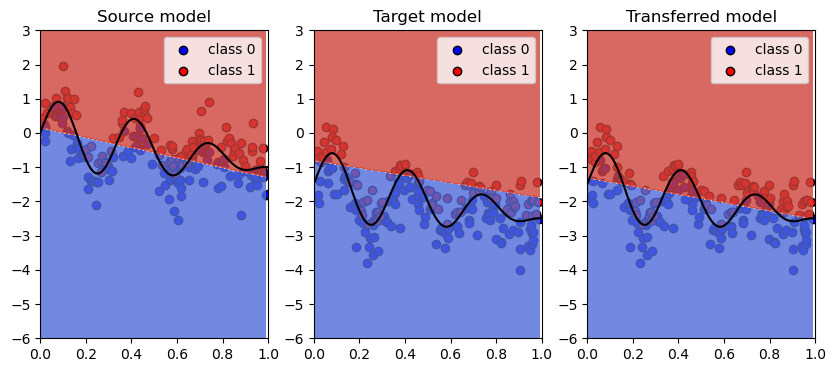

In [110]:
plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 4))

plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')
plot_dots(ax[2],Xt,yt, title='Target data')

plot_1d_func(ax[0], fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')
plot_1d_func(ax[2], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')


plot_dec_func(ax[0], source_model,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model')
plot_dec_func(ax[1], only_tgt_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model')
plot_dec_func(ax[2], tr_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Transferred model')



<h2>Supervised transfer learning on decision tree based models </h2><a name="dt"></a>

<h3>Example 1 : decision tree for pseudo-periodic classification</h3><a name="dt_sin"></a>

In [111]:
np.random.seed(0)

MAX = 5
K_FOLD = 10
N_EST = 10
DT_only = False

# Source and Target classifiers :
if DT_only:
    clf_source = DecisionTreeClassifier(max_depth=MAX)
    clf_target = DecisionTreeClassifier(max_depth=MAX)
else:
    clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
    clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)    

#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))


Score Target model: 0.680
Score Source model: 0.605
Score Source model on Target: 0.553


In [112]:
clf_src = copy.deepcopy(clf_source)

methods = [
    'relab',
    'ser',
    'strut'
]
labels = [
    'relab',
    '$SER$',
    '$STRUT$'
]

mean_strut = 0
mean_relab = 0
mean_ser = 0

mean_auc_strut = 0
mean_auc_relab = 0
mean_auc_ser = 0

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    clfs = []
    scores = []
    auc_scores = []
        
    for m,method in enumerate(methods):      

        clf_transfer = copy.deepcopy(clf_source)

        if method == 'relab':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_relab = copy.deepcopy(transferred_model.estimator_)

        if method == 'ser':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="ser")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="ser")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_ser = copy.deepcopy(transferred_model.estimator_)
            
        if method == 'strut':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="strut")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="strut")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_strut = copy.deepcopy(transferred_model.estimator_)
            

        score = transferred_model.estimator_.score(X_tgt_test, Y_tgt_test)
        yp = transferred_model.estimator_.predict_proba(X_tgt_test)[:,1]
        auc_score = roc_auc_score(Y_tgt_test,yp)

        #print('Testing score transferred model ({}) : {:.3f}'.format(method, score))
        #print('Testing ROC AUC score transferred model ({}) : {:.3f}'.format(method, auc_score))

        clfs.append(transferred_model.estimator_)
        scores.append(score.copy())
        auc_scores.append(auc_score)

        
    k =+ 1
    
    mean_relab += scores[0]
    mean_ser += scores[1]
    mean_strut += scores[2]
    
    mean_auc_relab += scores[0]
    mean_auc_ser += scores[1]
    mean_auc_strut += scores[2]

mean_relab /= K_FOLD
mean_ser /= K_FOLD
mean_strut /= K_FOLD

mean_auc_relab /= K_FOLD
mean_auc_ser /= K_FOLD
mean_auc_strut /= K_FOLD

print('SCORE RELAB :',mean_relab)
print('SCORE SER :',mean_ser)
print('SCORE STRUT :',mean_strut)

print('AUC SCORE RELAB :',mean_auc_relab)
print('AUC SCORE SER :',mean_auc_ser)
print('AUC SCORE STRUT :',mean_auc_strut)

SCORE RELAB : 0.6099999999999999
SCORE SER : 0.775
SCORE STRUT : 0.78
AUC SCORE RELAB : 0.6099999999999999
AUC SCORE SER : 0.775
AUC SCORE STRUT : 0.78


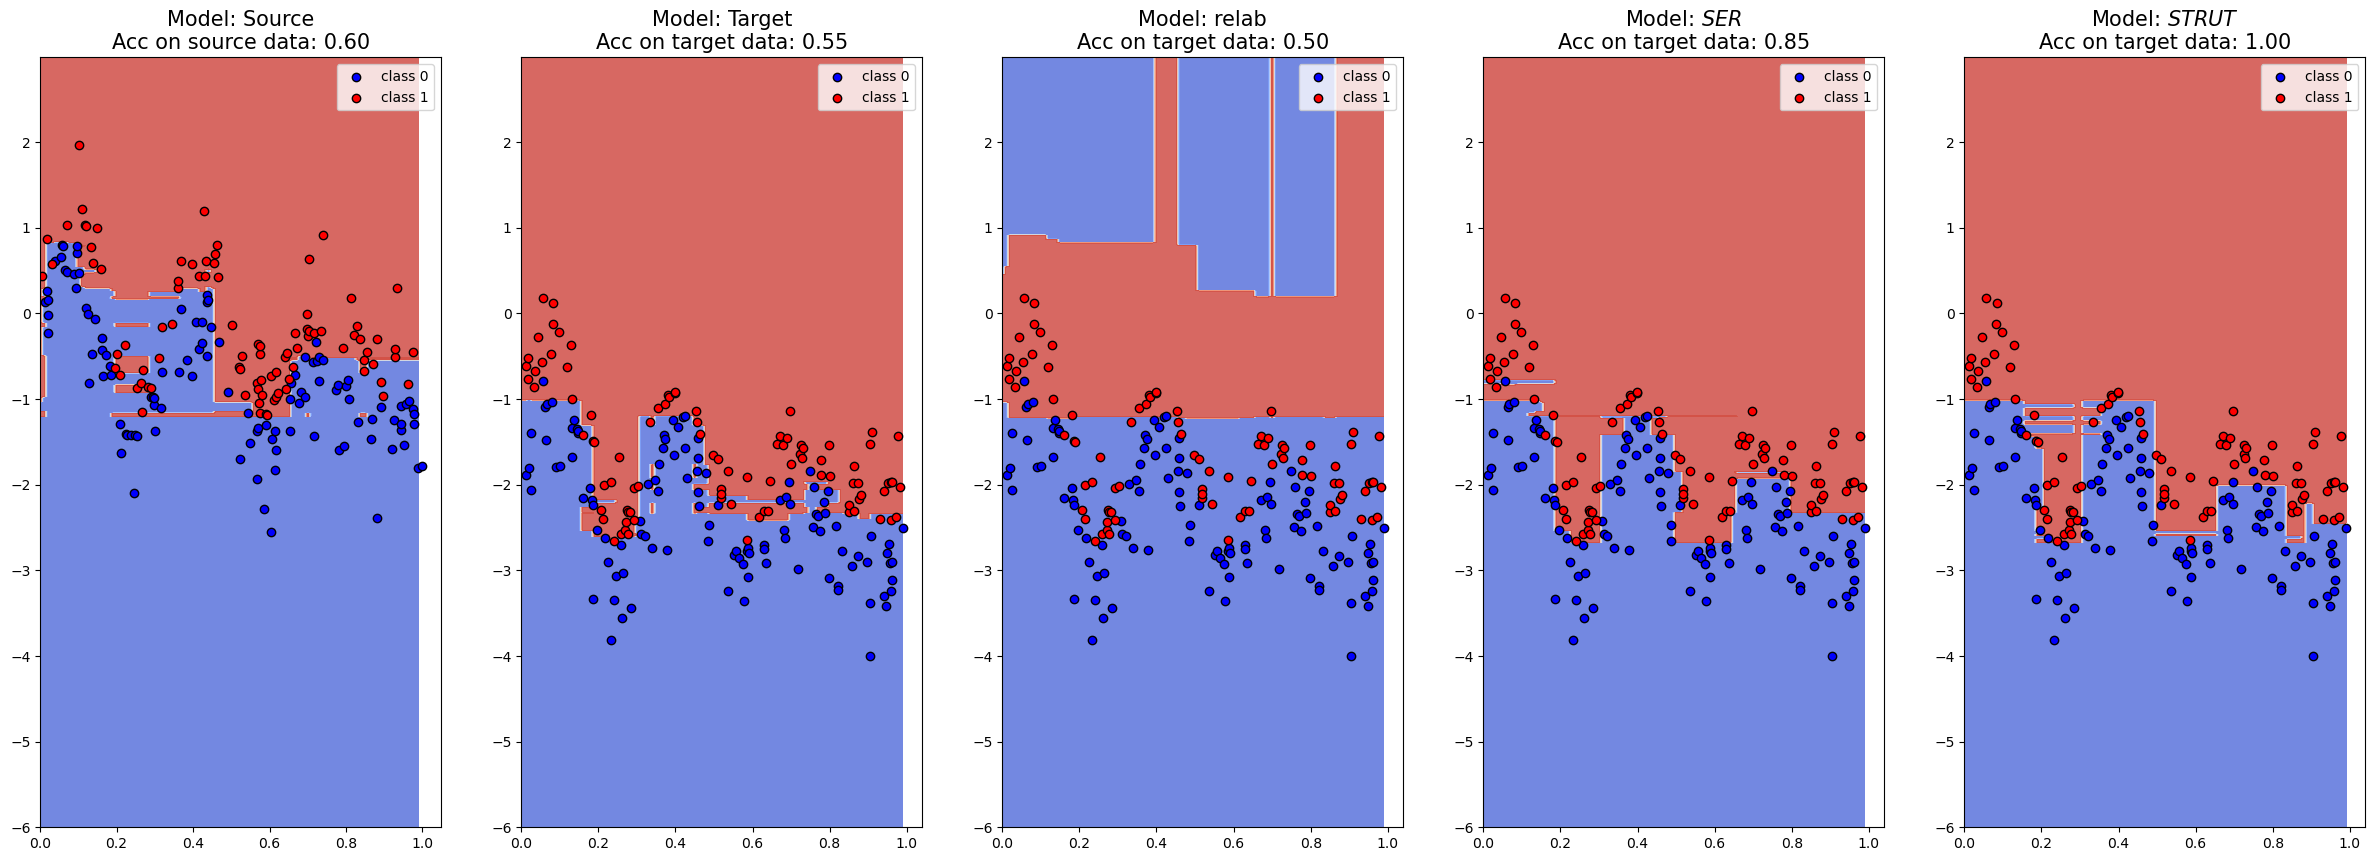

In [113]:
# Plot decision functions
fig, ax = plt.subplots(nrows=1, ncols=len(methods) + 2, figsize=(30, 10))


plot_dec_func(ax[0], clf_source,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model')
plot_dots(ax[0],Xs,ys, title='Source data')
ax[0].set_title('Model: Source\nAcc on source data: {:.2f}'.format(np.mean(score_src)),
                fontsize=15)

plot_dec_func(ax[1], clf_target,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model')
plot_dots(ax[1],Xt,yt, title='Source data')
ax[1].set_title('Model: Target\nAcc on target data: {:.2f}'.format(np.mean(score_src_tgt)),
                fontsize=15)


# Plot transfer models
for i, (method, label, score) in enumerate(zip(methods, labels, scores)):
    clf_transfer = clfs[i]
    
    plot_dec_func(ax[i+2], clf_transfer,  x_min, x_max, y_min, y_max, plot_step = plot_step, title=label)
    plot_dots(ax[i+2],Xt,yt, title=label)
    ax[i + 2].set_title('Model: {}\nAcc on target data: {:.2f}'.format(label, score),
                        fontsize=15)

plt.show()


<h3>Example 2 : decision tree for two gaussian clusters classification </h3><a name="dt_2clust"></a>

### Unique decision tree / One gaussian cluster per class

In [114]:
np.random.seed(0)

# Generate training source data
ns = 200
ns_perclass = ns // 2
mean_1 = (1, 1)
var_1 = np.diag([1, 1])
mean_2 = (3, 3)
var_2 = np.diag([2, 2])
Xs = np.r_[np.random.multivariate_normal(mean_1, var_1, size=ns_perclass),
           np.random.multivariate_normal(mean_2, var_2, size=ns_perclass)]
ys = np.zeros(ns)
ys[ns_perclass:] = 1

ns_test = 1000
ns_test_perclass = ns_test // 2
Xs_test = np.r_[np.random.multivariate_normal(mean_1, var_1, size=ns_test_perclass),
                np.random.multivariate_normal(mean_2, var_2, size=ns_test_perclass)]
ys_test = np.zeros(ns_test)
ys_test[ns_test_perclass:] = 1

# Generate training target data
nt = 50

# balanced
nt_0 = nt // 2

mean_1 = (6, 3)
var_1 = np.diag([4, 1])
mean_2 = (5, 5)
var_2 = np.diag([1, 3])
Xt = np.r_[np.random.multivariate_normal(mean_1, var_1, size=nt_0),
           np.random.multivariate_normal(mean_2, var_2, size=nt - nt_0)]
yt = np.zeros(nt)
yt[nt_0:] = 1
# Generate testing target data
nt_test = 1000
nt_test_perclass = nt_test // 2
Xt_test = np.r_[np.random.multivariate_normal(mean_1, var_1, size=nt_test_perclass),
                np.random.multivariate_normal(mean_2, var_2, size=nt_test_perclass)]
yt_test = np.zeros(nt_test)
yt_test[nt_test_perclass:] = 1

In [115]:
np.random.seed(0)

methods = [
    'relab',
    'ser',
    'strut'
]
labels = [
    'relab',
    '$SER$',
    '$STRUT$'
]

MAX_DEPTH = 5
clf_source = DecisionTreeClassifier(max_depth=MAX_DEPTH)
clf_source.fit(Xs, ys)
clf_target = DecisionTreeClassifier(max_depth=MAX_DEPTH)
clf_target.fit(Xt, yt)

score_src_src = clf_source.score(Xs_test, ys_test)
score_src_trgt = clf_source.score(Xt_test, yt_test)
print('Testing score Source model on Source data: {:.3f}'.format(score_src_src))
print('Testing score Source model on Target data: {:.3f}'.format(score_src_trgt))

clfs = []
scores = []
auc_scores = []

for m,method in enumerate(methods):      

    clf_transfer = copy.deepcopy(clf_source)

    if method == 'relab':
        transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="")
        transferred_model.fit(Xt,yt)
        clf_relab = copy.deepcopy(transferred_model)

    if method == 'ser':
        transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="ser")
        transferred_model.fit(Xt,yt)
        clf_ser = copy.deepcopy(transferred_model)

    if method == 'strut':
        transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="strut")
        transferred_model.fit(Xt,yt)
        clf_strut = copy.deepcopy(transferred_model)


    score = transferred_model.estimator_.score(Xt_test, yt_test)
    yp = transferred_model.estimator_.predict_proba(Xt_test)[:,1]
    auc_score = roc_auc_score(yt_test,yp)

    print('Testing score transferred model ({}) : {:.3f}'.format(method, score))
    print('Testing ROC AUC score transferred model ({}) : {:.3f}'.format(method, auc_score))

    clfs.append(transferred_model.estimator_)
    scores.append(score)
    auc_scores.append(auc_score)


Testing score Source model on Source data: 0.832
Testing score Source model on Target data: 0.513
getting
setting
Testing score transferred model (relab) : 0.676
Testing ROC AUC score transferred model (relab) : 0.676
getting
setting
Testing score transferred model (ser) : 0.713
Testing ROC AUC score transferred model (ser) : 0.713
getting
setting
Testing score transferred model (strut) : 0.743
Testing ROC AUC score transferred model (strut) : 0.723


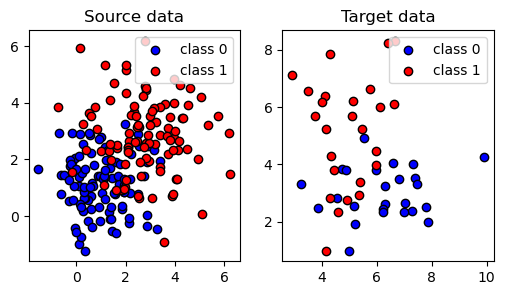

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6, 3))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

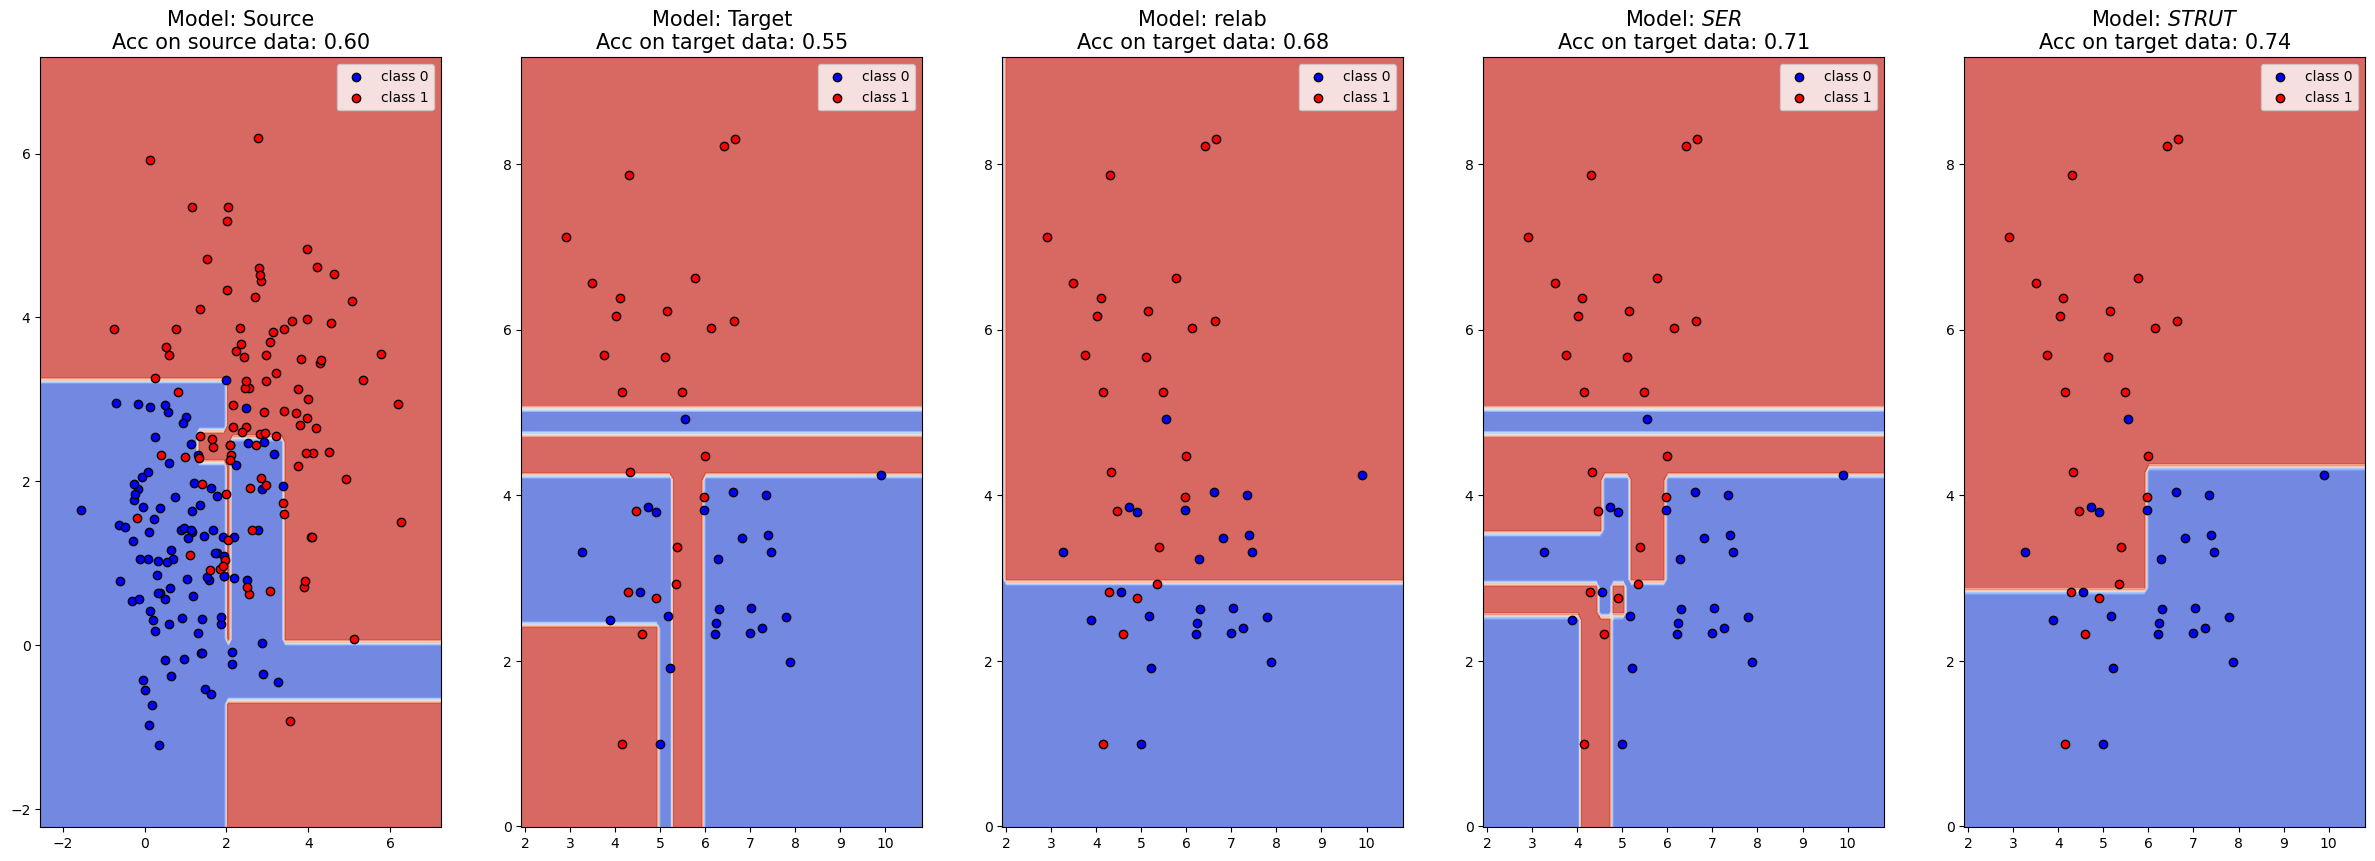

In [117]:
# Plot decision functions

plot_step = 0.1

fig, ax = plt.subplots(nrows=1, ncols=len(methods) + 2, figsize=(30, 10))

x_min, x_max = Xs[:, 0].min() - 1, Xs[:, 0].max() + 1
y_min, y_max = Xs[:, 1].min() - 1, Xs[:, 1].max() + 1

plot_dec_func(ax[0], clf_source,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model')
plot_dots(ax[0],Xs,ys, title='Source data')
ax[0].set_title('Model: Source\nAcc on source data: {:.2f}'.format(np.mean(score_src)),
                fontsize=15)

x_min, x_max = Xt[:, 0].min() - 1, Xt[:, 0].max() + 1
y_min, y_max = Xt[:, 1].min() - 1, Xt[:, 1].max() + 1

plot_dec_func(ax[1], clf_target,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model')
plot_dots(ax[1],Xt,yt, title='Source data')
ax[1].set_title('Model: Target\nAcc on target data: {:.2f}'.format(np.mean(score_src_tgt)),
                fontsize=15)


# Plot transfer models
for i, (method, label, score) in enumerate(zip(methods, labels, scores)):
    clf_transfer = clfs[i]
    
    plot_dec_func(ax[i+2], clf_transfer,  x_min, x_max, y_min, y_max, plot_step = plot_step, title=label)
    plot_dots(ax[i+2],Xt,yt, title=label)
    ax[i + 2].set_title('Model: {}\nAcc on target data: {:.2f}'.format(label, score),
                        fontsize=15)

plt.show()

In [118]:
from sklearn.tree import export_graphviz as exp_draw
from matplotlib import image
import subprocess
import os

from tree_plot_utils import TreeDot, highlight_different_nodes

your_path = './img/'


file_out = exp_draw(clf_source,out_file=your_path+'tree_src.dot',filled=True,impurity=False)
file_out = exp_draw(clf_ser.estimator_,out_file=your_path+'tree_ser.dot',filled=True,impurity=False)
file_out = exp_draw(clf_strut.estimator_,out_file=your_path+'tree_strut.dot',filled=True,impurity=False)


os.system('dot -Tpng '+your_path+'tree_src.dot -o '+your_path+'tree_src.png')
os.system('dot -Tpng '+your_path+'tree_ser.dot -o '+your_path+'tree_ser.png')
os.system('dot -Tpng '+your_path+'tree_strut.dot -o '+your_path+'tree_strut.png')

tree_img = image.imread(your_path+'tree_src.png')
tree_ser_img = image.imread(your_path+'tree_ser.png')
tree_strut_img = image.imread(your_path+'tree_strut.png')

T_D_src = TreeDot('tree_src.dot',your_path)
T_D_ser = TreeDot('tree_ser.dot',your_path)
T_D_strut = TreeDot('tree_strut.dot',your_path)

l1,l2 = highlight_different_nodes(clf_source,clf_ser.estimator_,0,0)


T_D_src._change_color(l1,'red','color',out_file='tree_src_updated.dot')
T_D_src = TreeDot('tree_src_updated.dot',your_path)
T_D_src._add_attribute(l1,'penwidth',3,out_file='tree_src_updated.dot')

T_D_ser._change_color(l2,'red','color',out_file='tree_ser_updated.dot')
T_D_ser = TreeDot('tree_ser_updated.dot',your_path)
T_D_ser._add_attribute(l2,'penwidth',3,out_file='tree_ser_updated.dot')

os.system('dot -Tpng '+your_path+'tree_src_updated.dot -o '+your_path+'tree_src_h.png')
os.system('dot -Tpng '+your_path+'tree_ser_updated.dot -o '+your_path+'tree_ser_h.png')

tree_src = image.imread(your_path+'tree_src_h.png')
tree_ser = image.imread(your_path+'tree_ser_h.png')

T_D_src = TreeDot('tree_src.dot',your_path)
T_D_ser = TreeDot('tree_ser.dot',your_path)
T_D_strut = TreeDot('tree_strut.dot',your_path)

l1,l2 = highlight_different_nodes(clf_source,clf_strut.estimator_,0,0,soft=True)


T_D_src._change_color(l1,'red','color',out_file='tree_src_updated2.dot')
T_D_src = TreeDot('tree_src_updated2.dot',your_path)
T_D_src._add_attribute(l1,'penwidth',3,out_file='tree_src_updated2.dot')

T_D_strut._change_color(l2,'red','color',out_file='tree_strut_updated.dot')
T_D_strut = TreeDot('tree_strut_updated.dot',your_path)
T_D_strut._add_attribute(l2,'penwidth',3,out_file='tree_strut_updated.dot')

os.system('dot -Tpng '+your_path+'tree_src_updated2.dot -o '+your_path+'tree_src_h2.png')
os.system('dot -Tpng '+your_path+'tree_strut_updated.dot -o '+your_path+'tree_strut_h.png')

tree_src2 = image.imread(your_path+'tree_src_h2.png')
tree_strut = image.imread(your_path+'tree_strut_h.png')

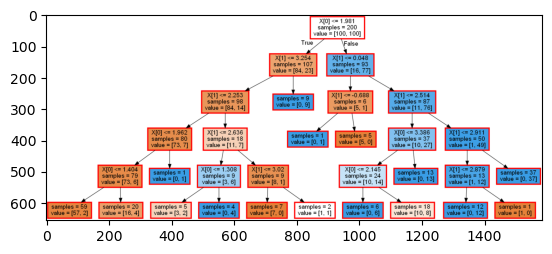

In [119]:
plt.imshow(tree_src)

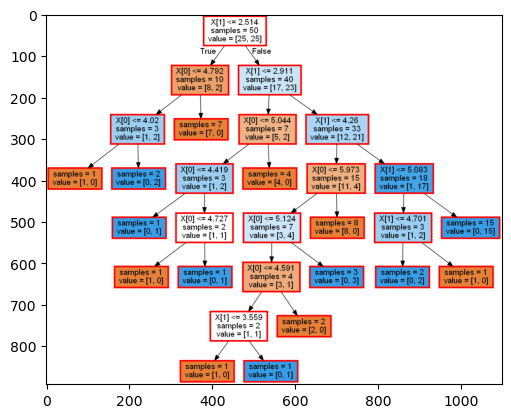

In [120]:
plt.imshow(tree_ser)

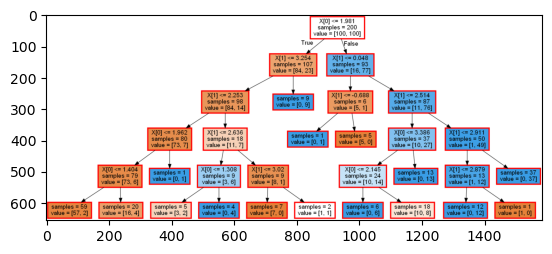

In [121]:
plt.imshow(tree_src2)

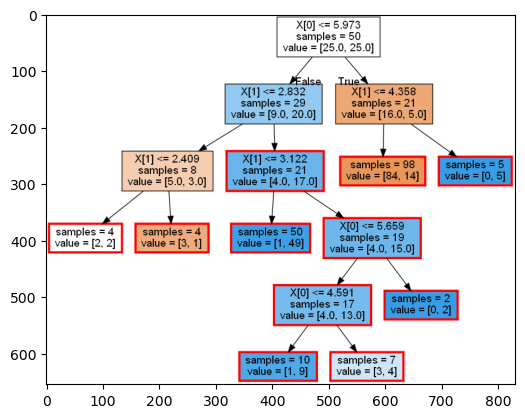

In [122]:
plt.imshow(tree_strut)

<h3>Example 3 : random forest for numerous gaussian clusters classification </h3><a name="rf_clust"></a>

In [123]:
from generate_synth_utils import create_N_clusters, create_clusters, translate_N_clusters, shrink_N_clusters
from generate_synth_utils import delete_N_clusters, add_N_clusters, generate_samples

#### No change between Source/Target clusters <a name="rf_nochange"></a>

In [124]:
np.random.seed(0)
N0=5
N1=5

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#No change:
Xt,yt=generate_samples(n_target_by_c,means_src,sigs_src,classes_src)

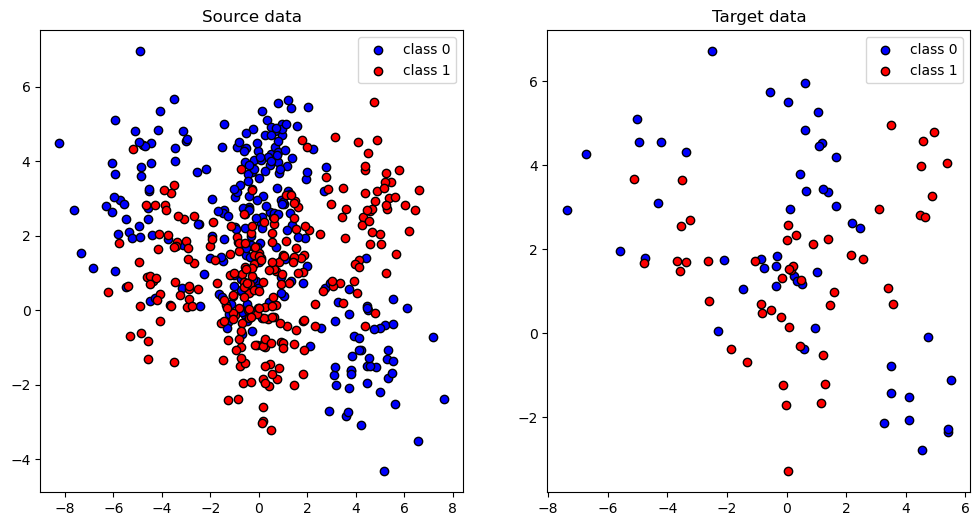

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [126]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.660
Score Source model: 0.692
Score Source model on Target: 0.755


In [127]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.640
Score SER model: 0.870


In [128]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)
DT_only = False
RF_SIZE = 10

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 
         
        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])
        
        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE  
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.68
    SER 0.6399999999999999
    STRF 0.7500000000000001
AUC SCORES:
    STRUT 0.754
    SER 0.702
    STRF 0.8320000000000001
AUC SCORES ON SRC:
    STRUT 0.7844864
    SER 0.7958752
    STRF 0.8675264


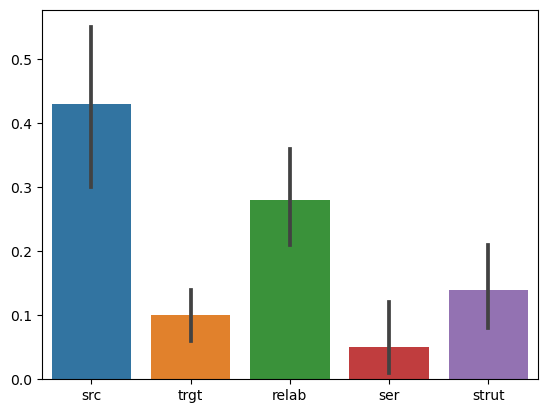

In [129]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

#### Redrawing new clusters (no link between Source/Target) <a name="rf_tgt"></a>

In [130]:
np.random.seed(0)
N0=5
N1=5

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#No change:
means_tgt,sigs_tgt,classes_tgt = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xt,yt=generate_samples(n_target_by_c,means_tgt,sigs_tgt,classes_tgt)

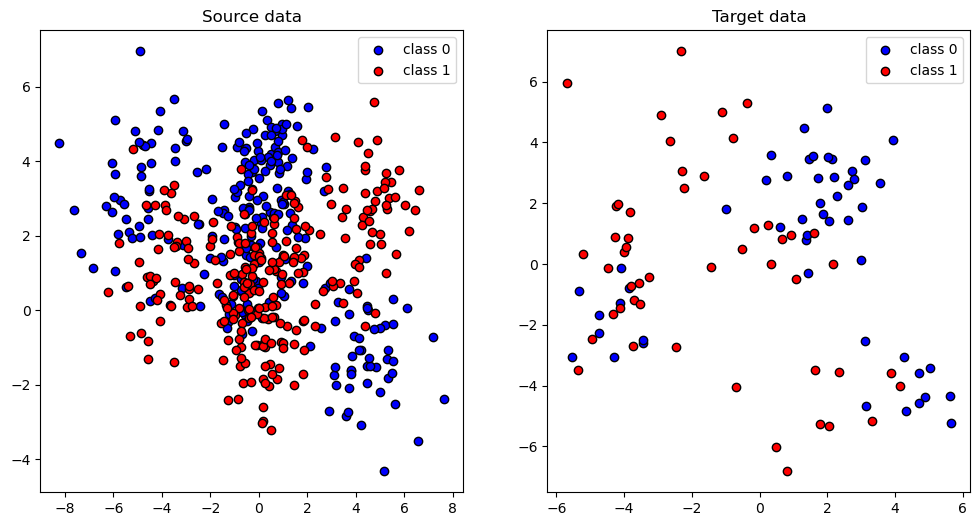

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [132]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.690
Score Source model: 0.666
Score Source model on Target: 0.539


In [133]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.730
Score SER model: 0.800


In [134]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)
DT_only = False
RF_SIZE = 10

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 
         
        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])
        
        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE  
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.6900000000000001
    SER 0.6799999999999999
    STRF 0.6400000000000001
AUC SCORES:
    STRUT 0.7380000000000001
    SER 0.7460000000000001
    STRF 0.728
AUC SCORES ON SRC:
    STRUT 0.5085048
    SER 0.5312647999999999
    STRF 0.5573775999999999


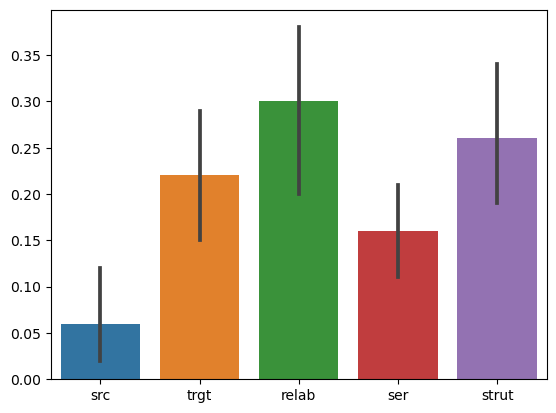

In [135]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

#### Translations between Source and Target <a name="rf_translation"></a>

In [136]:
np.random.seed(0)
N0=5
N1=5

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#Translation:
means,sigs,classes = translate_N_clusters(4,means_src,sigs_src,classes_src,mean_range=[-5,5],sig_range=[0.5,2])
Xt,yt=generate_samples(n_target_by_c,means,sigs,classes)

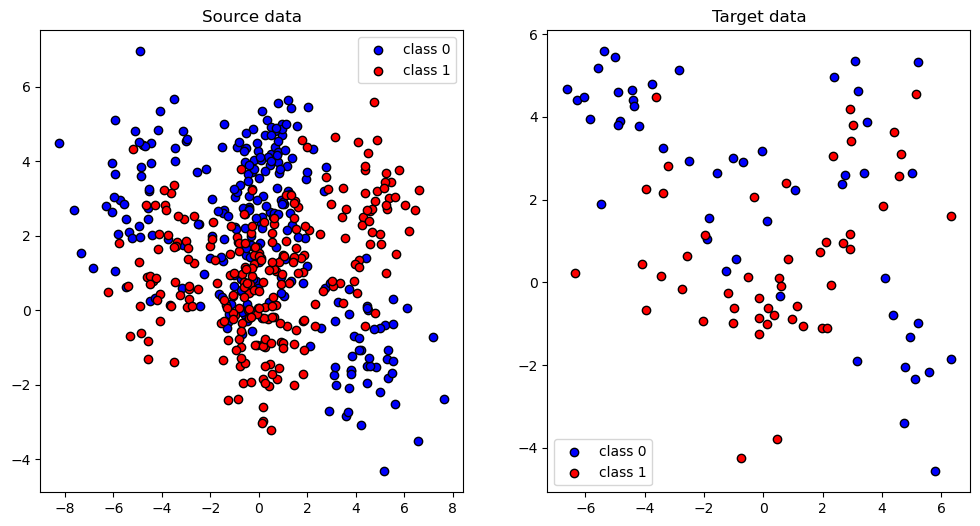

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [138]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.700
Score Source model: 0.714
Score Source model on Target: 0.804


In [139]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.660
Score SER model: 0.830


In [140]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)
DT_only = False
RF_SIZE = 10

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 
         
        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])
        
        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE  
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.67
    SER 0.68
    STRF 0.75
AUC SCORES:
    STRUT 0.776
    SER 0.812
    STRF 0.796
AUC SCORES ON SRC:
    STRUT 0.7668223999999999
    SER 0.7915783999999999
    STRF 0.8420592000000001


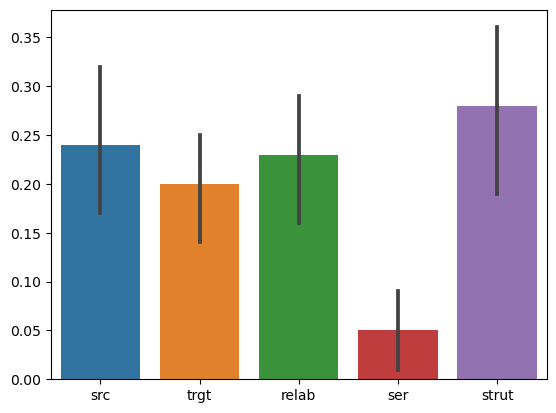

In [141]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

#### Addition/deletion of clusters <a name="rf_add_del"></a>

In [166]:
np.random.seed(0)

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#Addition/deletion:
means1,sigs1,classes1 = add_N_clusters(3,1,means_src,sigs_src,classes_src,mean_range=[-7,7],sig_range=[0.5,1])
means2,sigs2,classes2 = add_N_clusters(3,0,means1,sigs1,classes1,mean_range=[-7,7],sig_range=[0.5,1])
means,sigs,classes = delete_N_clusters(2,means2,sigs2,classes2)

Xt,yt=generate_samples(n_target_by_c,means,sigs,classes)

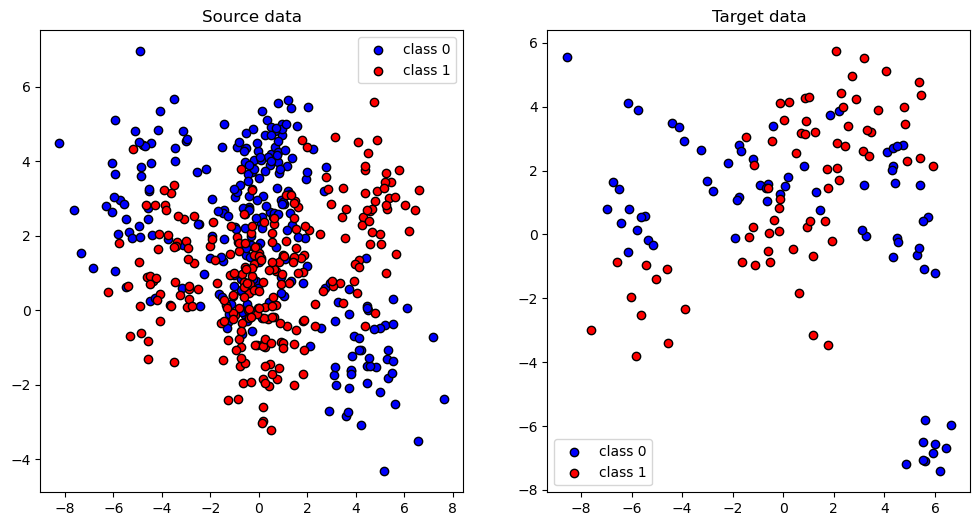

In [167]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [168]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1
    
print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.771
Score Source model: 0.694
Score Source model on Target: 0.629


In [169]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.764
Score SER model: 0.893


In [170]:
algo_list = ['src','target','relab','ser','strut']
n_versions = len(algo_list)

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test) 
         
        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]
        
        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test) 
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test) 
        
        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])
        
        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE  
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.7499999999999999
    SER 0.7928571428571427
    STRF 0.8285714285714286
AUC SCORES:
    STRUT 0.7979591836734694
    SER 0.8612244897959185
    STRF 0.886734693877551
AUC SCORES ON SRC:
    STRUT 0.5652375999999999
    SER 0.5692
    STRF 0.5750423999999998


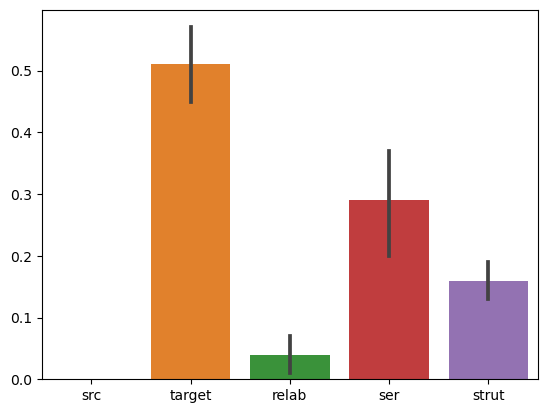

In [171]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)